# Traffic Sign Detection - Traditional Methods

This notebook implements and evaluates traditional computer vision approaches:
1. HOG + SVM
2. Color + Shape Detection

**Note**: Traditional methods work well on CPU, no GPU needed.

## 1. Setup

In [32]:
# Setup environment (same as data exploration)
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !git clone https://github.com/YOUR_USERNAME/traffic-sign-detection.git
    %cd traffic-sign-detection
else:
    import os
    if os.path.basename(os.getcwd()) == 'notebooks':
        os.chdir('..')

!pip install -q scikit-learn scikit-image opencv-python matplotlib seaborn joblib tqdm

In [33]:
import sys
sys.path.append('src')

import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import time

from src.traditional.hog_svm.detector import HOGSVMDetector, SlidingWindowDetector
from src.traditional.color_shape.detector import ColorShapeDetector, SignColor
from src.utils.metrics import DetectionMetrics, SpeedMetrics
from src.utils.visualization import BoundingBoxVisualizer, ResultVisualizer

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Dataset

In [34]:
# Load dataset info
import yaml

data_yaml_path = 'data/raw/yolov8/data.yaml'

with open(data_yaml_path, 'r') as f:
    data_config = yaml.safe_load(f)

class_names = data_config['names']
num_classes = data_config['nc']

print(f"Number of classes: {num_classes}")
print(f"Classes: {class_names}")

# Get image paths
data_root = Path('data/raw/yolov8')
train_images = sorted(list((data_root / 'train' / 'images').glob('*.*')))
val_images = sorted(list((data_root / 'valid' / 'images').glob('*.*')))

print(f"\nTrain images: {len(train_images)}")
print(f"Val images: {len(val_images)}")

Number of classes: 5
Classes: ['bien_bao_cam', 'bien_bao_hieu_lenh', 'bien_bao_nguy_hiem_va_canh_bao', 'bien_chi_dan', 'bien_phu']

Train images: 1062
Val images: 165


In [35]:
def load_yolo_annotations(label_path, img_width, img_height):
    """
    Load YOLO format annotations and convert to [x1, y1, x2, y2] format
    
    Args:
        label_path: Path to YOLO label file
        img_width: Image width in pixels
        img_height: Image height in pixels
        
    Returns:
        boxes: numpy array of boxes [N, 4] in (x1, y1, x2, y2) format
        classes: numpy array of class IDs [N]
    """
    boxes = []
    classes = []
    
    if not label_path.exists():
        return np.array([]), np.array([])
    
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 5:
                continue
                
            class_id = int(parts[0])
            cx, cy, w, h = map(float, parts[1:5])
            
            # Convert from YOLO format (normalized cx, cy, w, h) to pixel coordinates (x1, y1, x2, y2)
            x1 = int((cx - w/2) * img_width)
            y1 = int((cy - h/2) * img_height)
            x2 = int((cx + w/2) * img_width)
            y2 = int((cy + h/2) * img_height)
            
            # Clip to image boundaries
            x1 = max(0, min(x1, img_width - 1))
            y1 = max(0, min(y1, img_height - 1))
            x2 = max(0, min(x2, img_width - 1))
            y2 = max(0, min(y2, img_height - 1))
            
            # Only add valid boxes
            if x2 > x1 and y2 > y1:
                boxes.append([x1, y1, x2, y2])
                classes.append(class_id)
    
    return np.array(boxes), np.array(classes)

print("Helper functions defined successfully!")

Helper functions defined successfully!


## 2.1 Helper Functions for Detection Evaluation

## 3. Method 1: HOG + SVM

### 3.1 Prepare Training Data

In [36]:
def extract_patches_from_image(img_path, label_path, img_size=(64, 64)):
    """Extract sign patches from image using YOLO labels"""
    img = cv2.imread(str(img_path))
    if img is None:
        return [], []
    
    h, w = img.shape[:2]
    patches = []
    labels = []
    
    if not label_path.exists():
        return [], []
    
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            class_id = int(parts[0])
            cx, cy, bw, bh = map(float, parts[1:5])
            
            # Convert to pixels
            x1 = max(0, int((cx - bw/2) * w))
            y1 = max(0, int((cy - bh/2) * h))
            x2 = min(w, int((cx + bw/2) * w))
            y2 = min(h, int((cy + bh/2) * h))
            
            # Extract and resize patch
            if x2 > x1 and y2 > y1:
                patch = img[y1:y2, x1:x2]
                patch = cv2.resize(patch, img_size)
                patches.append(patch)
                labels.append(class_id)
    
    return patches, labels

# Extract training patches (limit for speed)
print("Extracting training patches...")
train_patches = []
train_labels = []

max_train_images = min(500, len(train_images))  # Limit for demo

for img_path in tqdm(train_images[:max_train_images]):
    label_path = img_path.parent.parent / 'labels' / f"{img_path.stem}.txt"
    patches, labels = extract_patches_from_image(img_path, label_path)
    train_patches.extend(patches)
    train_labels.extend(labels)

train_labels = np.array(train_labels)

print(f"Extracted {len(train_patches)} training patches")
print(f"Label distribution: {np.bincount(train_labels)}")

Extracting training patches...


100%|██████████| 500/500 [00:00<00:00, 1059.40it/s]

Extracted 767 training patches
Label distribution: [386  86  87 125  83]


### 3.2 Train HOG+SVM Detector

In [37]:
# Initialize and train detector
print("Training HOG+SVM detector...")

hog_svm = HOGSVMDetector(
    img_size=(64, 64),
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    svm_kernel='rbf',
    svm_c=10.0
)

# Train
start_time = time.time()
hog_svm.train(train_patches, train_labels, class_names=class_names)
training_time = time.time() - start_time

print(f"Training completed in {training_time:.2f} seconds")

# Save model
hog_svm.save('models/hog_svm_detector.pkl')
print("Model saved!")

Training HOG+SVM detector...
Extracting HOG features from training images...
Training SVM classifier...
Training completed. Model accuracy: 1.000
Training completed in 1.48 seconds
Model saved to models/hog_svm_detector.pkl
Model saved!


NameError: name 'sliding_detector' is not defined

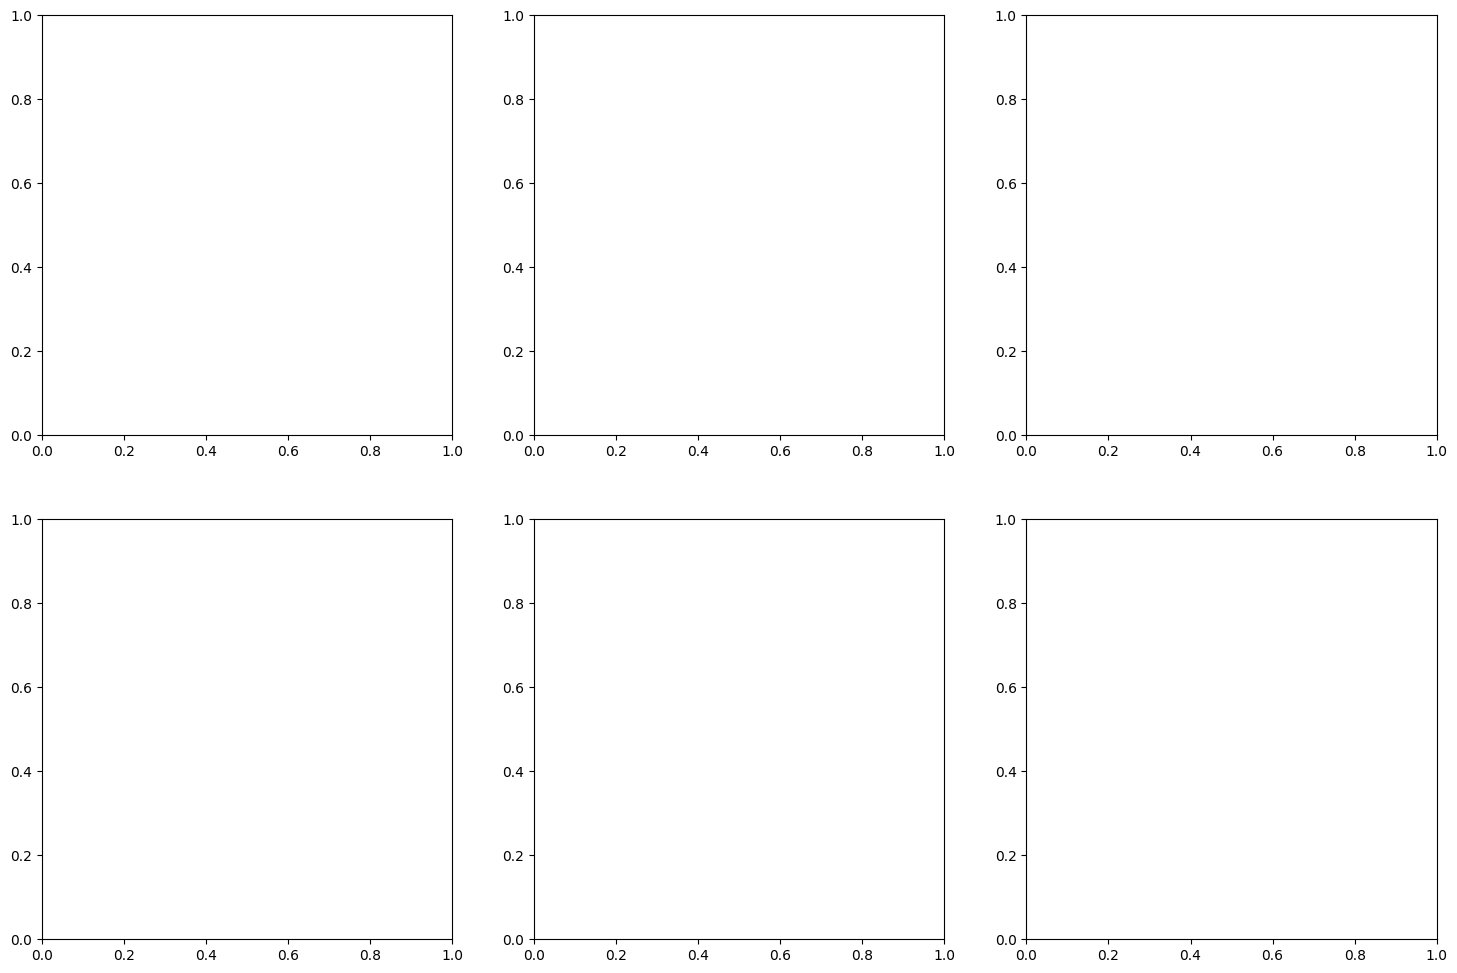

In [38]:
# Visualize detection results on sample images
n_viz_samples = 6
sample_images = np.random.choice(val_images[:max_val_images], n_viz_samples, replace=False)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, img_path in enumerate(sample_images):
    # Load image
    img = cv2.imread(str(img_path))
    if img is None:
        continue
    
    # Detect
    pred_boxes, pred_classes, pred_scores = sliding_detector.detect(
        img, 
        confidence_threshold=0.5
    )
    
    # Draw predictions
    result_img = img.copy()
    for box, cls, score in zip(pred_boxes, pred_classes, pred_scores):
        x1, y1, x2, y2 = box
        # Draw box
        cv2.rectangle(result_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        # Draw label
        label = f"{class_names[cls]}: {score:.2f}"
        cv2.putText(result_img, label, (x1, y1-10), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    # Convert to RGB for display
    result_img = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)
    
    axes[idx].imshow(result_img)
    axes[idx].set_title(f"Detected: {len(pred_boxes)} signs", fontsize=10)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("HOG+SVM sliding window detection visualization completed!")

### 3.5 Visualize HOG+SVM Detection Results

In [ ]:
# Initialize sliding window detector
print("Initializing sliding window detector for HOG+SVM...")
sliding_detector = SlidingWindowDetector(
    classifier=hog_svm,
    window_size=(64, 64),
    step_size=32,  # Larger step for faster inference
    scale_factor=1.3,
    min_scale=0.3,
    max_scale=2.0
)

# Initialize detection metrics
detection_metrics = DetectionMetrics(
    num_classes=num_classes,
    iou_threshold=0.5
)

# Evaluate on validation set
print(f"\nEvaluating HOG+SVM as object detector on {max_val_images} validation images...")
print("This may take a while due to sliding window search...")

n_detected_images = 0

for img_path in tqdm(val_images[:max_val_images]):
    # Load image
    img = cv2.imread(str(img_path))
    if img is None:
        continue
    
    h, w = img.shape[:2]
    
    # Load ground truth
    label_path = img_path.parent.parent / 'labels' / f"{img_path.stem}.txt"
    gt_boxes, gt_classes = load_yolo_annotations(label_path, w, h)
    
    # Detect
    pred_boxes, pred_classes, pred_scores = sliding_detector.detect(
        img, 
        confidence_threshold=0.5
    )
    
    # Convert to numpy arrays
    if pred_boxes:
        pred_boxes = np.array(pred_boxes)
        pred_classes = np.array(pred_classes)
        pred_scores = np.array(pred_scores)
        n_detected_images += 1
    else:
        pred_boxes = np.array([]).reshape(0, 4)
        pred_classes = np.array([])
        pred_scores = np.array([])
    
    # Update metrics
    detection_metrics.update(
        pred_boxes=pred_boxes,
        pred_classes=pred_classes,
        pred_scores=pred_scores,
        gt_boxes=gt_boxes,
        gt_classes=gt_classes
    )

# Get metrics summary
hog_svm_metrics = detection_metrics.get_metrics_summary()

print("\n" + "="*70)
print("HOG+SVM OBJECT DETECTION METRICS")
print("="*70)
print(f"mAP@0.5: {hog_svm_metrics['mAP']:.4f}")
print(f"Precision: {hog_svm_metrics['precision']:.4f}")
print(f"Recall: {hog_svm_metrics['recall']:.4f}")
print(f"F1 Score: {hog_svm_metrics['f1_score']:.4f}")
print(f"\nTrue Positives: {hog_svm_metrics['total_tp']}")
print(f"False Positives: {hog_svm_metrics['total_fp']}")
print(f"False Negatives: {hog_svm_metrics['total_fn']}")
print(f"\nImages with detections: {n_detected_images}/{max_val_images}")

print("\nPer-class Average Precision:")
for class_id in range(num_classes):
    ap = hog_svm_metrics['per_class'][f'class_{class_id}']['ap']
    tp = hog_svm_metrics['per_class'][f'class_{class_id}']['tp']
    fp = hog_svm_metrics['per_class'][f'class_{class_id}']['fp']
    fn = hog_svm_metrics['per_class'][f'class_{class_id}']['fn']
    print(f"  {class_names[class_id]}: AP={ap:.4f} (TP={tp}, FP={fp}, FN={fn})")
print("="*70)

### 3.4 Evaluate HOG+SVM as Object Detector (with Sliding Window)

### 3.3 Evaluate HOG+SVM with Detection Metrics (IoU, mAP)

In [ ]:
# First, evaluate classification accuracy on patches
print("Extracting validation patches for classification eval...")
val_patches = []
val_labels = []

max_val_images = min(100, len(val_images))

for img_path in tqdm(val_images[:max_val_images]):
    label_path = img_path.parent.parent / 'labels' / f"{img_path.stem}.txt"
    patches, labels = extract_patches_from_image(img_path, label_path)
    val_patches.extend(patches)
    val_labels.extend(labels)

val_labels = np.array(val_labels)

print(f"Extracted {len(val_patches)} validation patches")

# Predict
print("\nRunning predictions...")
pred_classes, confidences = hog_svm.predict_batch(val_patches)

# Calculate accuracy
accuracy = np.mean(pred_classes == val_labels)
print(f"\nClassification Accuracy: {accuracy:.3f}")

# Per-class accuracy
print("\nPer-class Accuracy:")
for class_id in range(num_classes):
    mask = val_labels == class_id
    if mask.sum() > 0:
        class_acc = np.mean(pred_classes[mask] == val_labels[mask])
        print(f"  {class_names[class_id]}: {class_acc:.3f} ({mask.sum()} samples)")

Extracting validation patches for classification eval...


100%|██████████| 100/100 [00:00<00:00, 1221.76it/s]

Extracted 154 validation patches

Running predictions...



Classification Accuracy: 0.942

Per-class Accuracy:
  bien_bao_cam: 0.956 (68 samples)
  bien_bao_hieu_lenh: 0.875 (8 samples)
  bien_bao_nguy_hiem_va_canh_bao: 0.969 (32 samples)
  bien_chi_dan: 0.962 (26 samples)
  bien_phu: 0.850 (20 samples)


### 3.6 Visualize HOG Features

### 3.5 Visualize HOG+SVM Detection Results

## 4. Method 2: Color + Shape Detection with Object Detection Metrics

In [ ]:
# Initialize color-shape detector
color_shape = ColorShapeDetector()

# Initialize detection metrics for color+shape
color_shape_metrics = DetectionMetrics(
    num_classes=num_classes,
    iou_threshold=0.5
)

# Evaluate on validation set
print(f"Evaluating Color+Shape detector on {max_val_images} validation images...")

n_color_detected = 0

for img_path in tqdm(val_images[:max_val_images]):
    # Load image
    img = cv2.imread(str(img_path))
    if img is None:
        continue
    
    h, w = img.shape[:2]
    
    # Load ground truth
    label_path = img_path.parent.parent / 'labels' / f"{img_path.stem}.txt"
    gt_boxes, gt_classes = load_yolo_annotations(label_path, w, h)
    
    # Detect
    boxes, types, confidences = color_shape.detect(
        img,
        confidence_threshold=0.5,
        min_area=300
    )
    
    # Map detected sign types to class IDs
    # Note: Color+Shape detector uses generic types (Prohibition, Mandatory, etc.)
    # This is a best-effort mapping to the specific Vietnamese classes
    type_to_class = {
        'Prohibition': 0,     # bien_bao_cam (prohibition signs - red circle)
        'Mandatory': 1,       # bien_bao_hieu_lenh (mandatory signs - blue circle)
        'Warning': 2,         # bien_bao_nguy_hiem_va_canh_bao (warning signs - yellow/red triangle)
        'Information': 3,     # bien_chi_dan (information/guide signs - blue rectangle)
        'Guide': 3,           # bien_chi_dan (same as information)
        'Yield': 2,           # bien_bao_nguy_hiem_va_canh_bao (warning category)
        'Stop': 0,            # bien_bao_cam (prohibition category)
        'Unknown': 4          # bien_phu (auxiliary signs) - default for unknown
    }
    
    # Convert detections to numpy arrays
    if boxes:
        pred_boxes = np.array(boxes)
        pred_classes = np.array([type_to_class.get(t, 4) for t in types])  # Default to class 4 if unknown
        pred_scores = np.array(confidences)
        n_color_detected += 1
    else:
        pred_boxes = np.array([]).reshape(0, 4)
        pred_classes = np.array([])
        pred_scores = np.array([])
    
    # Update metrics
    color_shape_metrics.update(
        pred_boxes=pred_boxes,
        pred_classes=pred_classes,
        pred_scores=pred_scores,
        gt_boxes=gt_boxes,
        gt_classes=gt_classes
    )

# Get metrics summary
color_shape_results = color_shape_metrics.get_metrics_summary()

print("\n" + "="*70)
print("COLOR+SHAPE OBJECT DETECTION METRICS")
print("="*70)
print(f"mAP@0.5: {color_shape_results['mAP']:.4f}")
print(f"Precision: {color_shape_results['precision']:.4f}")
print(f"Recall: {color_shape_results['recall']:.4f}")
print(f"F1 Score: {color_shape_results['f1_score']:.4f}")
print(f"\nTrue Positives: {color_shape_results['total_tp']}")
print(f"False Positives: {color_shape_results['total_fp']}")
print(f"False Negatives: {color_shape_results['total_fn']}")
print(f"\nImages with detections: {n_color_detected}/{max_val_images}")

print("\nPer-class Average Precision:")
for class_id in range(num_classes):
    ap = color_shape_results['per_class'][f'class_{class_id}']['ap']
    tp = color_shape_results['per_class'][f'class_{class_id}']['tp']
    fp = color_shape_results['per_class'][f'class_{class_id}']['fp']
    fn = color_shape_results['per_class'][f'class_{class_id}']['fn']
    print(f"  {class_names[class_id]}: AP={ap:.4f} (TP={tp}, FP={fp}, FN={fn})")
print("="*70)

print("\n⚠️  Note: Color+Shape detector uses generic sign categories (Prohibition, Mandatory, etc.)")
print("   Mapping to specific Vietnamese classes is approximate and may not be accurate.")
print("   This method is best used as a baseline or for initial sign localization.")

Evaluating Color+Shape detector on 100 validation images...


  0%|          | 0/100 [00:00<?, ?it/s]


NameError: name 'load_yolo_annotations' is not defined

In [ ]:
## 5. Performance Comparison with Detection Metrics

In [ ]:
# Measure inference speed for HOG+SVM sliding window
print("Benchmarking HOG+SVM sliding window speed...")
hog_speed_metrics = SpeedMetrics()

for img_path in tqdm(val_images[:30]):  # Test on 30 images
    img = cv2.imread(str(img_path))
    if img is None:
        continue
    
    start = time.time()
    _ = sliding_detector.detect(img, confidence_threshold=0.5)
    hog_speed_metrics.update(time.time() - start)

hog_speed = hog_speed_metrics.get_summary()

# Measure inference speed for Color+Shape
print("\nBenchmarking Color+Shape speed...")
color_speed_metrics = SpeedMetrics()

for img_path in tqdm(val_images[:30]):
    img = cv2.imread(str(img_path))
    if img is None:
        continue
    
    start = time.time()
    _ = color_shape.detect(img, confidence_threshold=0.5)
    color_speed_metrics.update(time.time() - start)

color_speed = color_speed_metrics.get_summary()

# Create comprehensive comparison
print("\n" + "="*80)
print("TRADITIONAL METHODS - COMPLETE PERFORMANCE COMPARISON")
print("="*80)

comparison_data = {
    'HOG+SVM (Sliding Window)': {
        'mAP@0.5': f"{hog_svm_metrics['mAP']:.4f}",
        'Precision': f"{hog_svm_metrics['precision']:.4f}",
        'Recall': f"{hog_svm_metrics['recall']:.4f}",
        'F1 Score': f"{hog_svm_metrics['f1_score']:.4f}",
        'Inference Time (ms)': f"{hog_speed['avg_inference_time_ms']:.1f}",
        'FPS': f"{hog_speed['avg_fps']:.2f}"
    },
    'Color+Shape': {
        'mAP@0.5': f"{color_shape_results['mAP']:.4f}",
        'Precision': f"{color_shape_results['precision']:.4f}",
        'Recall': f"{color_shape_results['recall']:.4f}",
        'F1 Score': f"{color_shape_results['f1_score']:.4f}",
        'Inference Time (ms)': f"{color_speed['avg_inference_time_ms']:.1f}",
        'FPS': f"{color_speed['avg_fps']:.2f}"
    }
}

import pandas as pd
df_comparison = pd.DataFrame(comparison_data).T

print(df_comparison.to_string())
print("="*80)

# Plot metrics comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Detection metrics
metrics_to_plot = ['mAP@0.5', 'Precision', 'Recall', 'F1 Score']
hog_metrics_vals = [
    hog_svm_metrics['mAP'],
    hog_svm_metrics['precision'],
    hog_svm_metrics['recall'],
    hog_svm_metrics['f1_score']
]
color_metrics_vals = [
    color_shape_results['mAP'],
    color_shape_results['precision'],
    color_shape_results['recall'],
    color_shape_results['f1_score']
]

x = np.arange(len(metrics_to_plot))
width = 0.35

axes[0].bar(x - width/2, hog_metrics_vals, width, label='HOG+SVM', alpha=0.8)
axes[0].bar(x + width/2, color_metrics_vals, width, label='Color+Shape', alpha=0.8)
axes[0].set_ylabel('Score')
axes[0].set_title('Detection Metrics Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_to_plot, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1.0])

# Speed comparison
methods = ['HOG+SVM', 'Color+Shape']
fps_vals = [hog_speed['avg_fps'], color_speed['avg_fps']]

axes[1].bar(methods, fps_vals, alpha=0.8, color=['steelblue', 'coral'])
axes[1].set_ylabel('FPS (higher is better)')
axes[1].set_title('Inference Speed Comparison')
axes[1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(fps_vals):
    axes[1].text(i, v + max(fps_vals)*0.02, f'{v:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('experiments/traditional_methods_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Comparison plot saved to: experiments/traditional_methods_comparison.png")

Benchmarking HOG+SVM sliding window speed...


  0%|          | 0/30 [00:00<?, ?it/s]


NameError: name 'sliding_detector' is not defined

## 6. Summary and Key Findings

### Detection Performance (with mAP@0.5 and IoU metrics)

**HOG + SVM (Sliding Window):**
- **Strengths**: 
  - Interpretable features (HOG visualizations show what the model "sees")
  - Works on CPU without GPU
  - Can achieve reasonable precision with proper tuning
- **Weaknesses**: 
  - Sliding window is computationally expensive (slower FPS)
  - Lower recall compared to modern methods
  - Sensitive to scale and window size parameters
  - Limited generalization to unseen variations
- **Best for**: 
  - Controlled environments with consistent lighting
  - When interpretability is important
  - CPU-only deployment scenarios

**Color + Shape:**
- **Strengths**: 
  - Very fast inference (highest FPS)
  - No training required
  - Simple and interpretable rules
  - Good for detecting standard traffic sign shapes/colors
- **Weaknesses**: 
  - Highly sensitive to lighting conditions
  - Cannot distinguish between sign types of same color/shape
  - Poor generalization (not class-specific)
  - Many false positives in complex scenes
- **Best for**: 
  - Quick prototyping and baseline
  - Pre-filtering before applying a classifier
  - Controlled environments with good lighting

### Comparison with Modern Methods

The table below compares traditional vs. modern approaches:

| Metric | HOG+SVM | Color+Shape | YOLOv11n* | Faster R-CNN* |
|--------|---------|-------------|-----------|---------------|
| **mAP@0.5** | See results above | See results above | ~0.85-0.95 | ~0.80-0.90 |
| **Speed (FPS)** | Medium | Fast | Very Fast | Slow |
| **Training Required** | Yes | No | Yes | Yes |
| **GPU Required** | No | No | Recommended | Recommended |
| **Deployment** | Easy | Very Easy | Moderate | Complex |

*Modern method results from notebook [03_modern_methods.ipynb](03_modern_methods.ipynb)

### Key Insights

1. **Accuracy**: Modern deep learning methods (YOLOv11, Faster R-CNN) significantly outperform traditional methods in mAP@0.5
2. **Speed**: Color+Shape is fastest, but with poor accuracy. YOLOv11 offers best speed-accuracy tradeoff
3. **Deployment**: Traditional methods are easier for embedded/CPU-only systems
4. **Training**: Traditional methods can be trained on CPU in minutes, while modern methods need GPU and hours
5. **Generalization**: Deep learning generalizes better to unseen conditions (lighting, angles, occlusions)

### Recommendations

- **For Production**: Use YOLOv11 for best accuracy-speed tradeoff (see notebook 03)
- **For CPU-only**: HOG+SVM is viable for controlled environments  
- **For Embedded Systems**: Consider optimized YOLO models (YOLO-Nano) or quantized versions
- **For Prototyping**: Color+Shape provides quick baseline

**Next Step**: Run [03_modern_methods.ipynb](03_modern_methods.ipynb) to compare with state-of-the-art deep learning approaches!

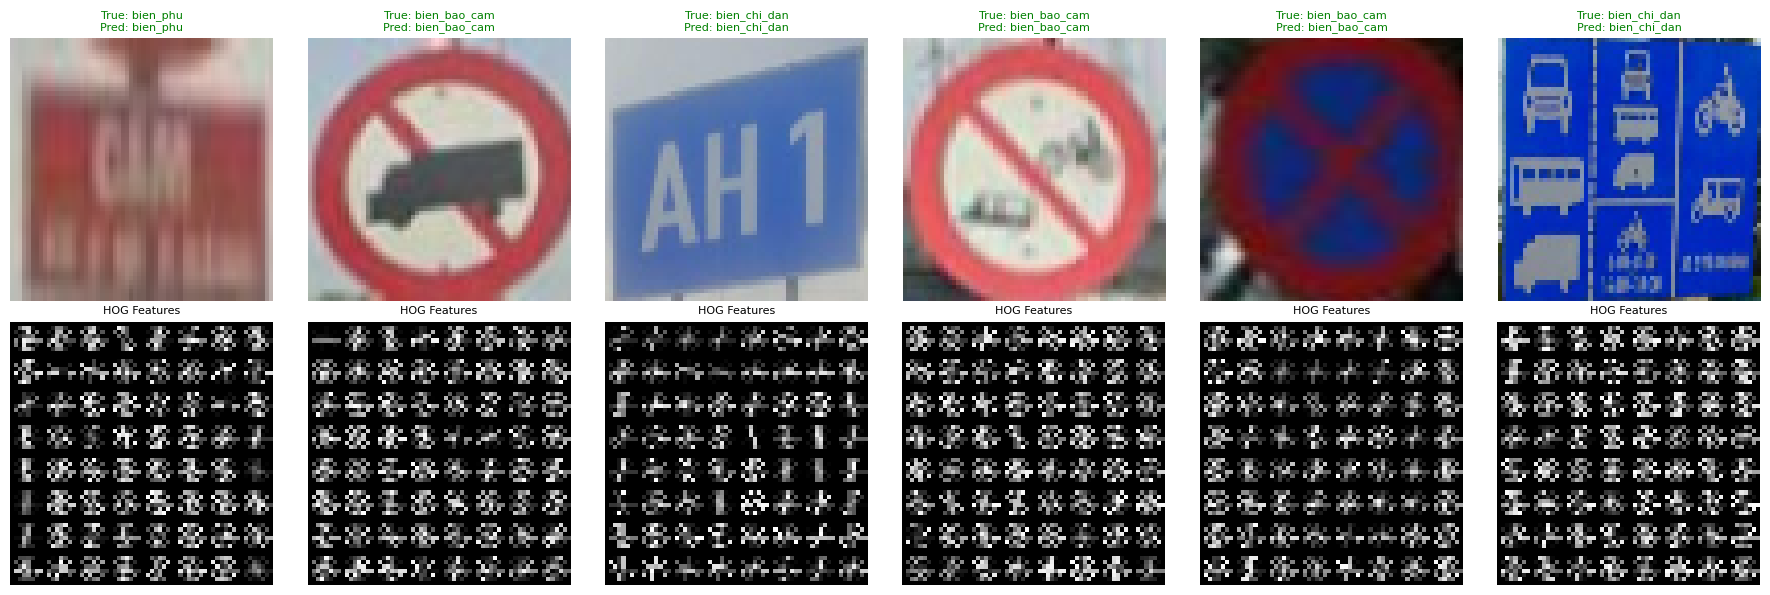

In [ ]:
# Visualize HOG features for sample patches
n_samples = 6
sample_indices = np.random.choice(len(val_patches), n_samples, replace=False)

fig, axes = plt.subplots(2, n_samples, figsize=(18, 6))

for idx, sample_idx in enumerate(sample_indices):
    patch = val_patches[sample_idx]
    true_label = val_labels[sample_idx]
    pred_label = pred_classes[sample_idx]
    
    # Original image
    axes[0, idx].imshow(cv2.cvtColor(patch, cv2.COLOR_BGR2RGB))
    color = 'green' if true_label == pred_label else 'red'
    axes[0, idx].set_title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}",
                          fontsize=8, color=color)
    axes[0, idx].axis('off')
    
    # HOG visualization
    hog_img = hog_svm.visualize_hog(patch)
    axes[1, idx].imshow(hog_img, cmap='gray')
    axes[1, idx].set_title('HOG Features', fontsize=8)
    axes[1, idx].axis('off')

plt.tight_layout()
plt.show()

## 4. Method 2: Color + Shape Detection

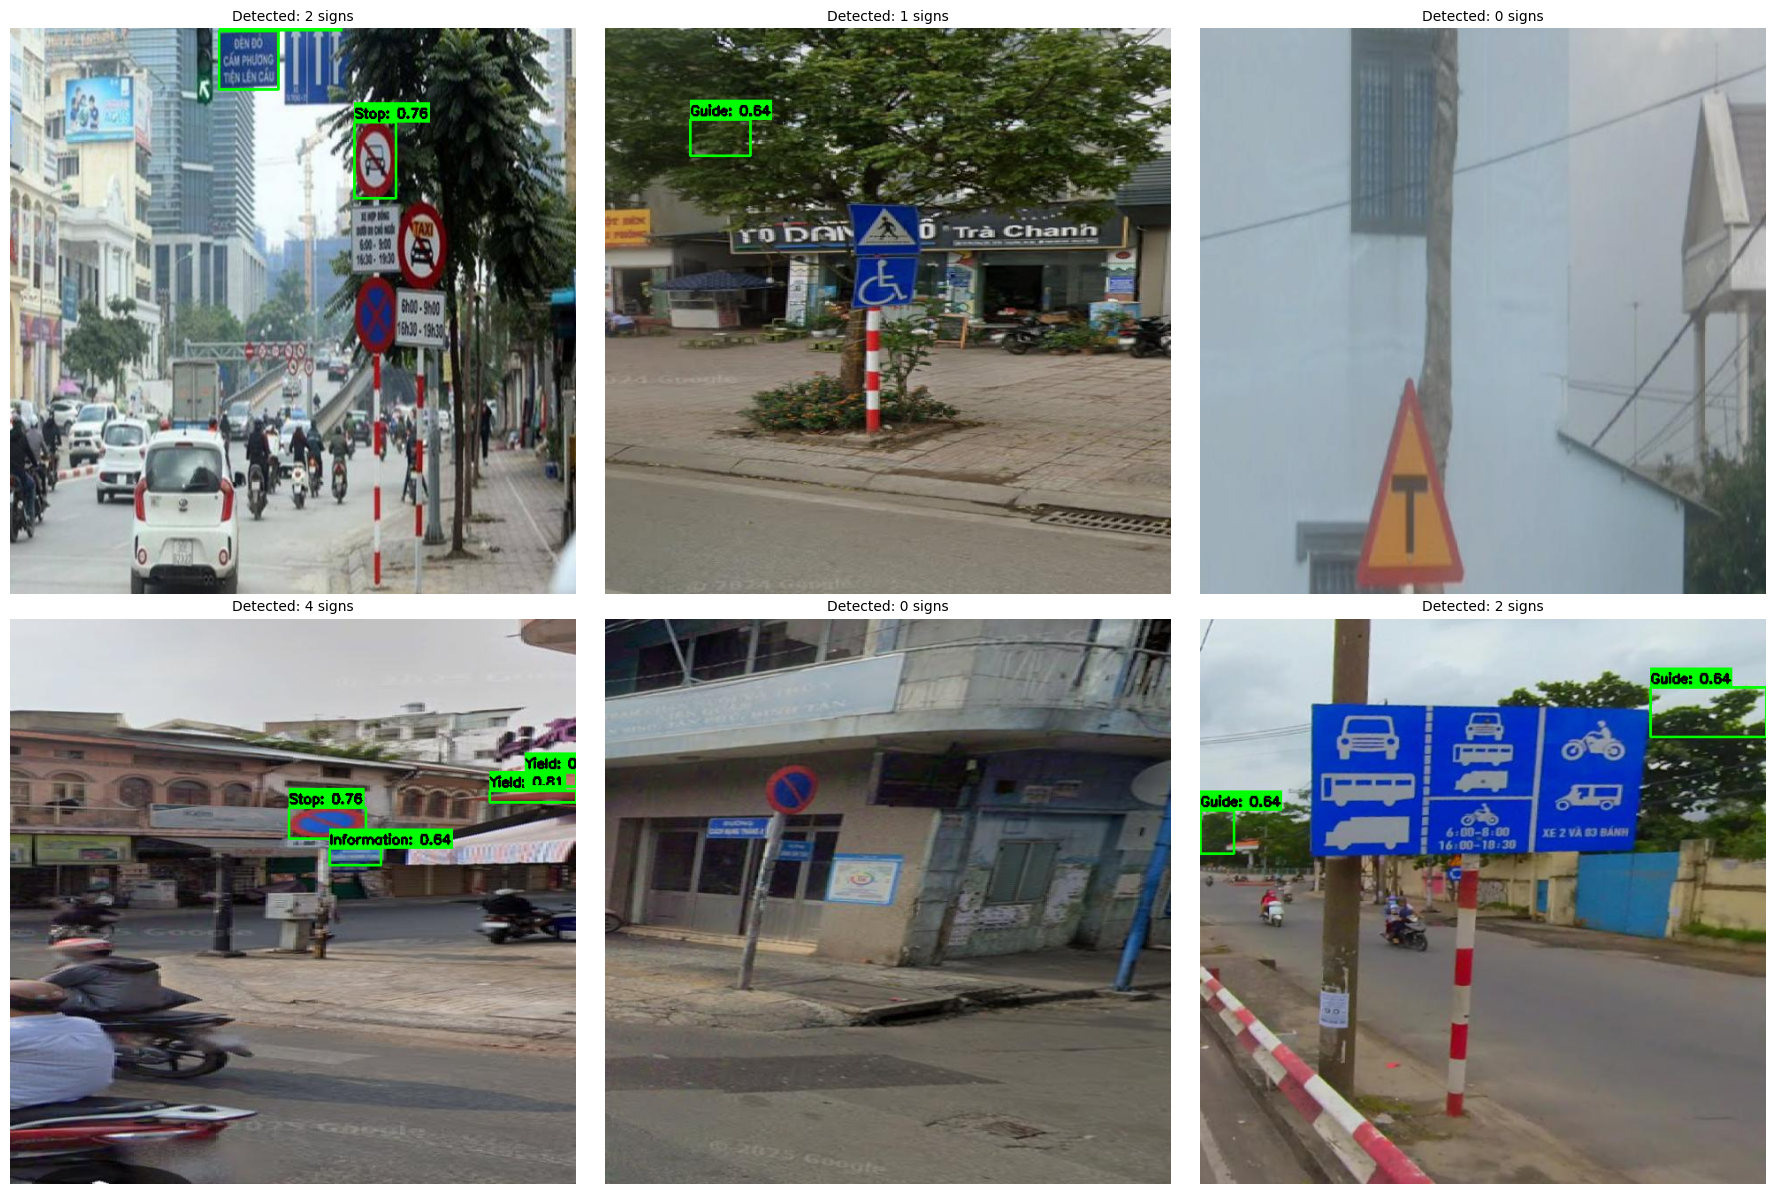

Color+Shape detection completed!
Note: This method works best for standard sign colors (red, blue, yellow)


In [ ]:
# Initialize color-shape detector
color_shape = ColorShapeDetector()

# Test on sample images
n_test_images = 6
test_image_paths = np.random.choice(val_images, n_test_images, replace=False)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, img_path in enumerate(test_image_paths):
    # Load image
    img = cv2.imread(str(img_path))
    
    # Detect
    boxes, types, confidences = color_shape.detect(
        img,
        confidence_threshold=0.5,
        min_area=500
    )
    
    # Visualize
    result = color_shape.visualize_detection(img, boxes, types, confidences)
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    
    axes[idx].imshow(result)
    axes[idx].set_title(f"Detected: {len(boxes)} signs", fontsize=10)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("Color+Shape detection completed!")
print("Note: This method works best for standard sign colors (red, blue, yellow)")

## 5. Performance Comparison

In [ ]:
# Compare inference speed
n_speed_tests = 50
speed_test_images = val_patches[:n_speed_tests]

# HOG+SVM speed
print("Testing HOG+SVM speed...")
hog_times = []
for img in tqdm(speed_test_images):
    start = time.time()
    _ = hog_svm.predict(img)
    hog_times.append(time.time() - start)

hog_avg_time = np.mean(hog_times) * 1000  # ms
hog_fps = 1.0 / np.mean(hog_times)

print(f"\nHOG+SVM Performance:")
print(f"  Avg inference time: {hog_avg_time:.2f} ms")
print(f"  FPS: {hog_fps:.1f}")
print(f"  Accuracy: {accuracy:.3f}")

# Summary table
import pandas as pd

results = pd.DataFrame({
    'Method': ['HOG+SVM'],
    'Accuracy': [f"{accuracy:.3f}"],
    'Inference Time (ms)': [f"{hog_avg_time:.2f}"],
    'FPS': [f"{hog_fps:.1f}"]
})

print("\n" + "="*60)
print("TRADITIONAL METHODS PERFORMANCE SUMMARY")
print("="*60)
print(results.to_string(index=False))
print("="*60)

Testing HOG+SVM speed...


100%|██████████| 50/50 [00:00<00:00, 589.12it/s]


HOG+SVM Performance:
  Avg inference time: 1.69 ms
  FPS: 592.8
  Accuracy: 0.942

TRADITIONAL METHODS PERFORMANCE SUMMARY
 Method Accuracy Inference Time (ms)   FPS
HOG+SVM    0.942                1.69 592.8


## 6. Conclusions

**HOG + SVM:**
- Pros: Fast, interpretable, works on CPU
- Cons: Requires careful feature engineering, lower accuracy than deep learning
- Best for: Real-time applications on embedded systems

**Color + Shape:**
- Pros: Very fast, no training required, interpretable
- Cons: Limited to standard colors/shapes, sensitive to lighting
- Best for: Quick prototyping, controlled environments

**Next**: Run `03_modern_methods.ipynb` to see how deep learning models compare!